# Import dependencies

In [1]:
# data manipulation

import pandas as pd
import numpy as np

# Datavisualisation and transformation

import cv2
import imghdr
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Datasets manipulation and neural network
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Preparation and Model Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Utilities

import time
import gc
import requests
import os
import pathlib

C:\Users\Spantler\AppData\Local\Temp\ipykernel_13436\3130436303.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Remove dodgy images

In [2]:
data_dir = 'dataset' 

In [3]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [5]:
data = list()

for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        label_remove = dirname.split("\\")[-1]
        image = os.path.join(dirname, filename)
        data.append((label_remove, image))

In [6]:
df = pd.DataFrame(data, columns=["label", "image"])
df.head()

,label,image
0,dew,./dataset\dew\2208.jpg
1,dew,./dataset\dew\2209.jpg
2,dew,./dataset\dew\2210.jpg
3,dew,./dataset\dew\2211.jpg
4,dew,./dataset\dew\2212.jpg


# Data Visualisation

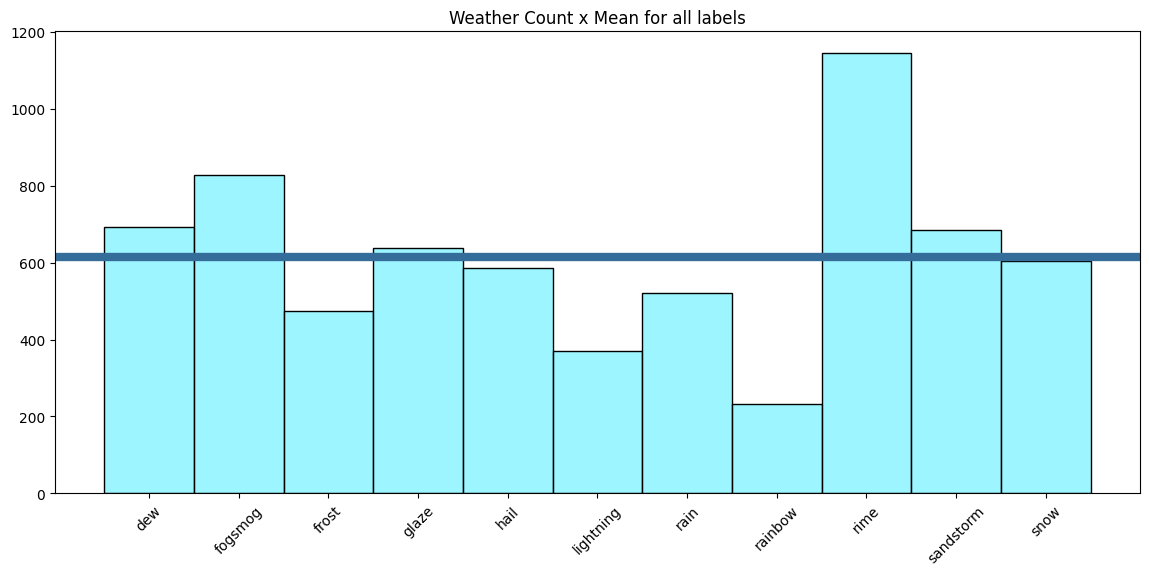

In [7]:
ax = sns.histplot(data=df, x="label", color="#7df2ff")
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby("label").count().mean().mean(), lw=6, color="#346c9a")
plt.xticks(rotation=45)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Weather Count x Mean for all labels")

plt.show()

In [8]:
unique_labels = df['label'].unique()
unique_labels


array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

In [9]:
examples = pd.DataFrame([])
for label in unique_labels:
    examples = pd.concat([examples, df.query(f"label == '{label}'").sample(1)])

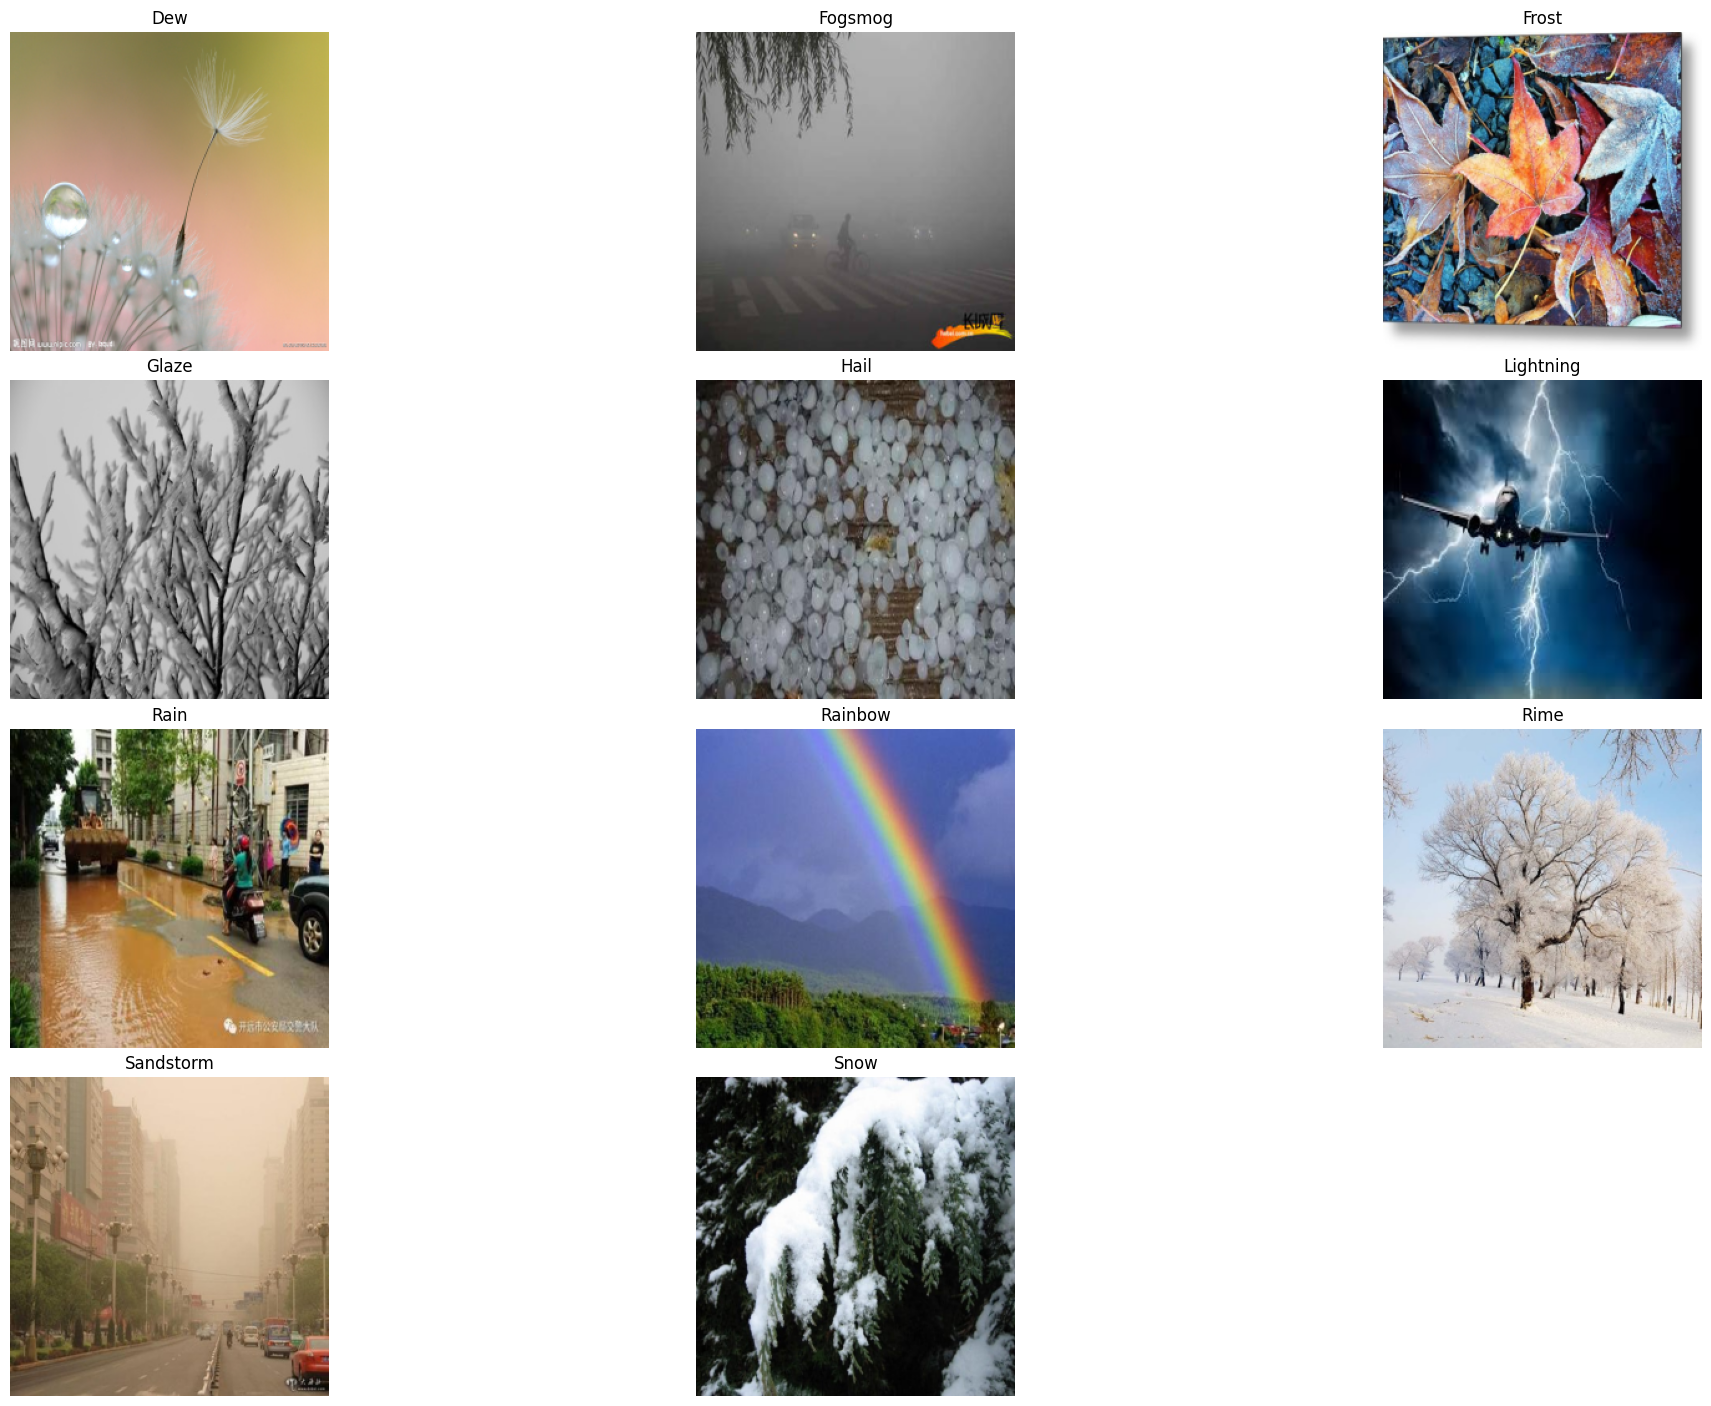

In [10]:
fig = plt.figure(figsize=(22, 14))
for index, row in examples.reset_index().iterrows():
    ax = plt.subplot(4, 3, index + 1)
    image = cv2.imread(row["image"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    ax.set_title(row["label"].title())
    ax.axis("off")

fig.tight_layout(pad=0.5)
plt.show()

# Train and Test Split

In [11]:
# Make new base directory
original_dataset_dir = 'weather/'
base_dir = 'weather-split/'
os.mkdir(base_dir)

In [12]:
#create two folders (train and validation)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

#Under train folder create five folders 
# (cloud, folly, rainy, shine, sunrise)

train_dew_dir = os.path.join(train_dir, 'dew')
os.mkdir(train_dew_dir)

train_fogsmog_dir = os.path.join(train_dir, 'fogsmog')
os.mkdir(train_fogsmog_dir)

train_frost_dir = os.path.join(train_dir, 'frost')
os.mkdir(train_frost_dir)

train_glaze_dir = os.path.join(train_dir, 'glaze')
os.mkdir(train_glaze_dir)

train_hail_dir = os.path.join(train_dir, 'hail')
os.mkdir(train_hail_dir)

train_lightning_dir = os.path.join(train_dir, 'lightning')
os.mkdir(train_lightning_dir)

train_rain_dir = os.path.join(train_dir, 'rain')
os.mkdir(train_rain_dir)

train_rainbow_dir = os.path.join(train_dir, 'rainbow')
os.mkdir(train_rainbow_dir)

train_rime_dir = os.path.join(train_dir, 'rime')
os.mkdir(train_rime_dir)

train_sandstorm_dir = os.path.join(train_dir, 'sandstorm')
os.mkdir(train_sandstorm_dir)

train_snow_dir = os.path.join(train_dir, 'snow')
os.mkdir(train_snow_dir)


#Under validation folder create five folders 
# (cloud, folly, rainy, shine, sunrise)

validation_dew_dir = os.path.join(validation_dir, 'dew')
os.mkdir(validation_dew_dir)

validation_fogsmog_dir = os.path.join(validation_dir, 'fogsmog')
os.mkdir(validation_fogsmog_dir)

validation_frost_dir = os.path.join(validation_dir, 'frost')
os.mkdir(validation_frost_dir)

validation_glaze_dir = os.path.join(validation_dir, 'glaze')
os.mkdir(validation_glaze_dir)

validation_hail_dir = os.path.join(validation_dir, 'hail')
os.mkdir(validation_hail_dir)

validation_lightning_dir = os.path.join(validation_dir, 'lightning')
os.mkdir(validation_lightning_dir)

validation_rain_dir = os.path.join(validation_dir, 'rain')
os.mkdir(validation_rain_dir)

validation_rainbow_dir = os.path.join(validation_dir, 'rainbow')
os.mkdir(validation_rainbow_dir)

validation_rime_dir = os.path.join(validation_dir, 'rime')
os.mkdir(validation_rime_dir)

validation_sandstorm_dir = os.path.join(validation_dir, 'sandstorm')
os.mkdir(validation_sandstorm_dir)

validation_snow_dir = os.path.join(validation_dir, 'snow')
os.mkdir(validation_snow_dir)

In [13]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

In [14]:
DEW_SOURCE_DIR = 'weather/dew/'
TRAINING_DEW_DIR = 'weather-split/train/dew/'
VALID_DEW_DIR = 'weather-split/validation/dew/'

FOGSMOG_SOURCE_DIR = 'weather/fogsmog/'
TRAINING_FOGSMOG_DIR = 'weather-split/train/fogsmog/'
VALID_FOGSMOG_DIR = 'weather-split/validation/fogsmog/'

FROST_SOURCE_DIR = 'weather/frost/'
TRAINING_FROST_DIR = 'weather-split/train/frost/'
VALID_FROST_DIR = 'weather-split/validation/frost/'

GLAZE_SOURCE_DIR = 'weather/glaze/'
TRAINING_GLAZE_DIR = 'weather-split/train/glaze/'
VALID_GLAZE_DIR = 'weather-split/validation/glaze/'

HAIL_SOURCE_DIR = 'weather/hail/'
TRAINING_HAIL_DIR = 'weather-split/train/hail/'
VALID_HAIL_DIR = 'weather-split/validation/hail/'

LIGHTNING_SOURCE_DIR = 'weather/lightning/'
TRAINING_LIGHTNING_DIR = 'weather-split/train/lightning/'
VALID_LIGHTNING_DIR = 'weather-split/validation/lightning/'

RAIN_SOURCE_DIR = 'weather/rain/'
TRAINING_RAIN_DIR = 'weather-split/train/rain/'
VALID_RAIN_DIR = 'weather-split/validation/rain/'

RAINBOW_SOURCE_DIR = 'weather/rainbow/'
TRAINING_RAINBOW_DIR = 'weather-split/train/rainbow/'
VALID_RAINBOW_DIR = 'weather-split/validation/rainbow/'

RIME_SOURCE_DIR = 'weather/rime/'
TRAINING_RIME_DIR = 'weather-split/train/rime/'
VALID_RIME_DIR = 'weather-split/validation/rime/'

SANDSTORM_SOURCE_DIR = 'weather/sandstorm/'
TRAINING_SANDSTORM_DIR = 'weather-split/train/sandstorm/'
VALID_SANDSTORM_DIR = 'weather-split/validation/sandstorm/'

SNOW_SOURCE_DIR = 'weather/snow/'
TRAINING_SNOW_DIR = 'weather-split/train/snow/'
VALID_SNOW_DIR = 'weather-split/validation/snow/'


In [15]:
import os
import random
from shutil import copyfile

split_size = .8

split_data(DEW_SOURCE_DIR,TRAINING_DEW_DIR,VALID_DEW_DIR,split_size)
split_data(SNOW_SOURCE_DIR,TRAINING_SNOW_DIR,VALID_SNOW_DIR,split_size)
split_data(FOGSMOG_SOURCE_DIR,TRAINING_FOGSMOG_DIR,VALID_FOGSMOG_DIR,split_size)
split_data(FROST_SOURCE_DIR,TRAINING_FROST_DIR,VALID_FROST_DIR,split_size)
split_data(GLAZE_SOURCE_DIR,TRAINING_GLAZE_DIR,VALID_GLAZE_DIR,split_size)
split_data(HAIL_SOURCE_DIR,TRAINING_HAIL_DIR,VALID_HAIL_DIR,split_size)
split_data(LIGHTNING_SOURCE_DIR,TRAINING_LIGHTNING_DIR,VALID_LIGHTNING_DIR,split_size)
split_data(RAIN_SOURCE_DIR,TRAINING_RAIN_DIR,VALID_RAIN_DIR,split_size)
split_data(RAINBOW_SOURCE_DIR,TRAINING_RAINBOW_DIR,VALID_RAINBOW_DIR,split_size)
split_data(RIME_SOURCE_DIR,TRAINING_RIME_DIR,VALID_RIME_DIR,split_size)
split_data(SANDSTORM_SOURCE_DIR,TRAINING_SANDSTORM_DIR,VALID_SANDSTORM_DIR,split_size)


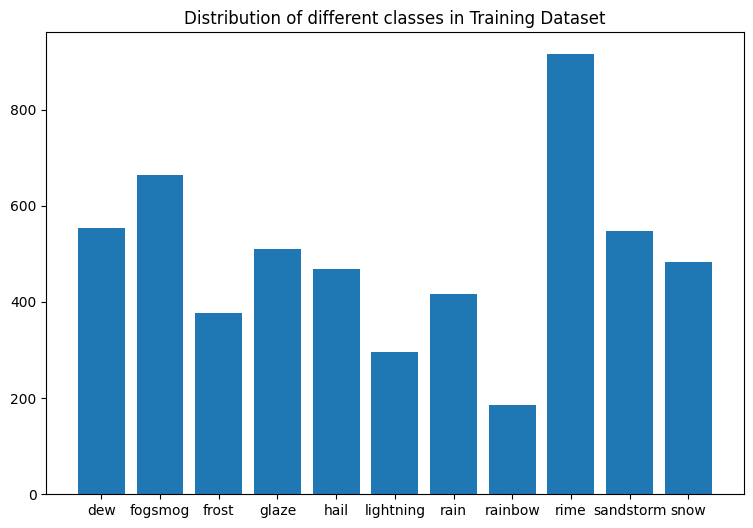

In [16]:
image_folder = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain','rainbow', 'rime', 'sandstorm', 'snow']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('weather-split/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

In [17]:
for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain','rainbow', 'rime', 'sandstorm', 'snow']:
    print('Training {} images are: '.format(i)+str(len(os.listdir('weather-split/train/'+i+'/'))))

Training dew images are: 553
Training fogsmog images are: 663
Training frost images are: 378
Training glaze images are: 511
Training hail images are: 468
Training lightning images are: 296
Training rain images are: 416
Training rainbow images are: 185
Training rime images are: 915
Training sandstorm images are: 548
Training snow images are: 484


# Data Augmentation

In [18]:
img_width=256; img_height=256
batch_size=16

In [19]:
TRAINING_DIR = 'weather-split/train/'

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 5417 images belonging to 11 classes.


In [20]:
VALIDATION_DIR = 'weather-split/validation/'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 1357 images belonging to 11 classes.


# Building the CNN Model

In [21]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
best_model_file = 'models/CNN_aug_best_weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [22]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(11, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        3

# Model Compiling and training

In [23]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [24]:
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

Epoch 1/100
339/339 [==============================] - 422s 1s/step - loss: 2.1685 - accuracy: 0.2352 - val_loss: 1.8702 - val_accuracy: 0.3795
Epoch 2/100
339/339 [==============================] - 368s 1s/step - loss: 1.8307 - accuracy: 0.3869 - val_loss: 1.5679 - val_accuracy: 0.4775
Epoch 3/100
339/339 [==============================] - 290s 854ms/step - loss: 1.5651 - accuracy: 0.4563 - val_loss: 1.3991 - val_accuracy: 0.4982
Epoch 4/100
339/339 [==============================] - 267s 788ms/step - loss: 1.4597 - accuracy: 0.4862 - val_loss: 1.3721 - val_accuracy: 0.5018
Epoch 5/100
339/339 [==============================] - 281s 829ms/step - loss: 1.3428 - accuracy: 0.5300 - val_loss: 1.2845 - val_accuracy: 0.5438
Epoch 6/100
339/339 [==============================] - 266s 783ms/step - loss: 1.3213 - accuracy: 0.5361 - val_loss: 1.2150 - val_accuracy: 0.5696
Epoch 7/100
339/339 [==============================] - 272s 802ms/step - loss: 1.2553 - accuracy: 0.5649 - val_loss: 1.2667 

339/339 [==============================] - 285s 841ms/step - loss: 0.9371 - accuracy: 0.6659 - val_loss: 0.9364 - val_accuracy: 0.6890
Epoch 28/100
339/339 [==============================] - 297s 876ms/step - loss: 0.9135 - accuracy: 0.6740 - val_loss: 0.9786 - val_accuracy: 0.6875
Epoch 29/100
339/339 [==============================] - 291s 858ms/step - loss: 0.9252 - accuracy: 0.6740 - val_loss: 0.9145 - val_accuracy: 0.7008
Epoch 30/100
339/339 [==============================] - 285s 840ms/step - loss: 0.9048 - accuracy: 0.6836 - val_loss: 1.0288 - val_accuracy: 0.6544
Epoch 31/100
339/339 [==============================] - 288s 850ms/step - loss: 0.9024 - accuracy: 0.6829 - val_loss: 1.0622 - val_accuracy: 0.6271
Epoch 32/100
339/339 [==============================] - 304s 895ms/step - loss: 0.8835 - accuracy: 0.6939 - val_loss: 1.0188 - val_accuracy: 0.6514
Epoch 33/100
339/339 [==============================] - 304s 897ms/step - loss: 0.9045 - accuracy: 0.6869 - val_loss: 1.0347 

339/339 [==============================] - 414s 1s/step - loss: 0.7709 - accuracy: 0.7301 - val_loss: 0.9181 - val_accuracy: 0.7001
Epoch 55/100
339/339 [==============================] - 380s 1s/step - loss: 0.7549 - accuracy: 0.7331 - val_loss: 0.8758 - val_accuracy: 0.7200
Epoch 56/100
339/339 [==============================] - 362s 1s/step - loss: 0.7466 - accuracy: 0.7358 - val_loss: 0.9344 - val_accuracy: 0.6971
Epoch 57/100
339/339 [==============================] - 338s 995ms/step - loss: 0.7336 - accuracy: 0.7403 - val_loss: 1.0610 - val_accuracy: 0.6905
Epoch 58/100
339/339 [==============================] - 438s 1s/step - loss: 0.7519 - accuracy: 0.7408 - val_loss: 0.9886 - val_accuracy: 0.6993
Epoch 59/100
339/339 [==============================] - 452s 1s/step - loss: 0.7665 - accuracy: 0.7312 - val_loss: 1.0391 - val_accuracy: 0.7067
Epoch 60/100
339/339 [==============================] - 420s 1s/step - loss: 0.7614 - accuracy: 0.7310 - val_loss: 0.9285 - val_accuracy: 0.

Epoch 81/100
339/339 [==============================] - 289s 851ms/step - loss: 0.7134 - accuracy: 0.7489 - val_loss: 0.9005 - val_accuracy: 0.7074
Epoch 82/100
339/339 [==============================] - 290s 855ms/step - loss: 0.7069 - accuracy: 0.7504 - val_loss: 0.9461 - val_accuracy: 0.7045
Epoch 83/100
339/339 [==============================] - 291s 858ms/step - loss: 0.6829 - accuracy: 0.7587 - val_loss: 0.8893 - val_accuracy: 0.7089
Epoch 84/100
339/339 [==============================] - 306s 901ms/step - loss: 0.6638 - accuracy: 0.7593 - val_loss: 1.0048 - val_accuracy: 0.7141
Epoch 85/100
339/339 [==============================] - 296s 873ms/step - loss: 0.7063 - accuracy: 0.7510 - val_loss: 0.9372 - val_accuracy: 0.6883
Epoch 86/100
339/339 [==============================] - 295s 868ms/step - loss: 0.6527 - accuracy: 0.7622 - val_loss: 0.9930 - val_accuracy: 0.6912
Epoch 87/100
339/339 [==============================] - 291s 858ms/step - loss: 0.7071 - accuracy: 0.7515 - val_

# Training and validation accuracy and loss plot

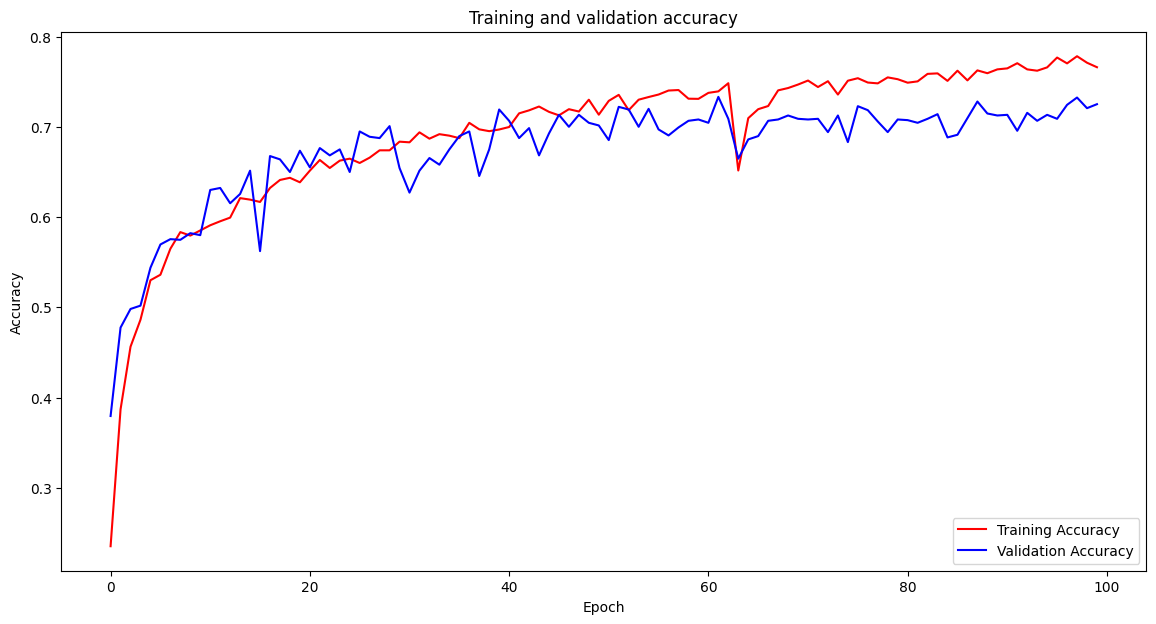

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

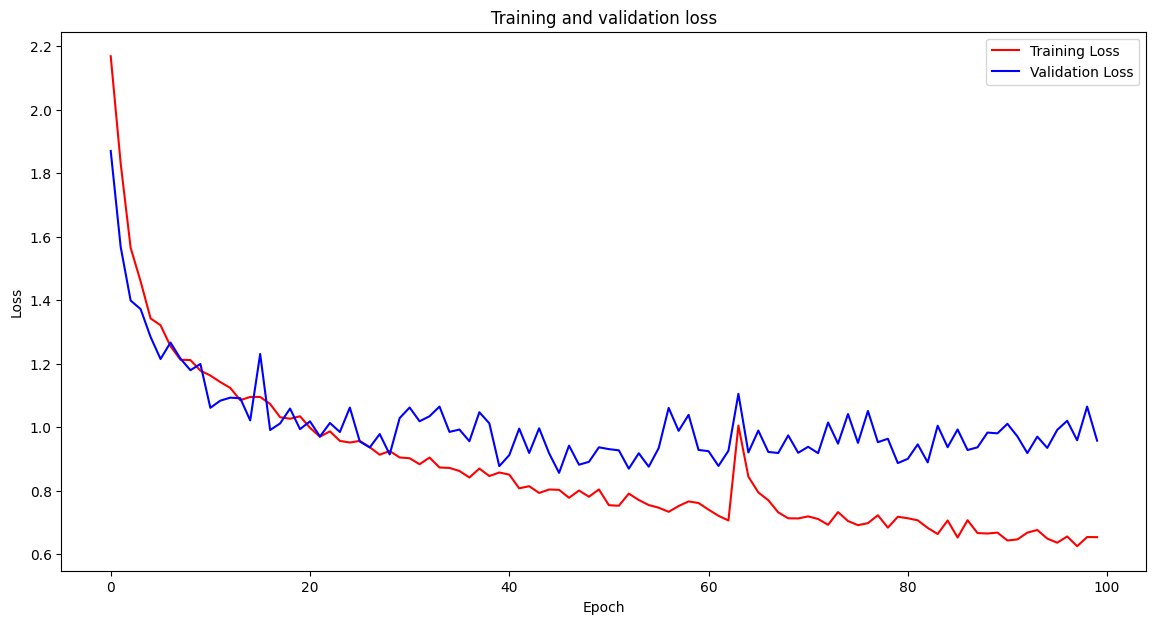

In [26]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

# Test performance on test data

In [32]:
## Test Performance on Test Data
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a /= 255.
    return a

In [38]:
##from tensorflow.keras.models import load_model

# Load the saved best model
##model = load_model('models/CNN_aug_best_weights.h5')

# Define a function to make predictions on a single image
def predict_weather(image_path, model):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    class_labels = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
    return class_labels[predicted_class]



In [39]:
test_image_path = 'Rain.jpeg'  # Replace with the path to your test image
predicted_weather = predict_weather(test_image_path, model)
print("Predicted Weather: ", predicted_weather)


1/1 [==============================] - 0s 65ms/step
Predicted Weather:  rain


In [40]:
test_image_path = 'snow.jpeg'  # Replace with the path to your test image
predicted_weather = predict_weather(test_image_path, model)
print("Predicted Weather: ", predicted_weather)


1/1 [==============================] - 0s 67ms/step
Predicted Weather:  snow
